In [1]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [2]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)

    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def bind(past, present):
    return np.multiply(past, present)

def reg_bind(past, present):
    pred = np.multiply(tv, present)
    return ((N-sim(pred, past))/float(N)) * np.multiply(past, present)

def bind_diff(past2, present1, present2):
    return np.multiply(present1, past2-present2)

def reg_bind_diff(past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    return ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)

def closed_bind(past, present):
    return np.dot(np.linalg.pinv(present), past)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def state_setup(state_length, letter_vecs, N, D, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

# EXPLAIN AWAY, PAST PRESENT TENSE DIFFERENCE
def explain_away_iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    th_vec = bound_vec.copy()
    
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            #mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            #states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv

    return states, coef_hists

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, atol, rtol, max_steps=500):
    th_vec = bound_vec.copy()
    all_converged = np.zeros(state_length-2)
    all_diffs = np.zeros((state_length-2, D))
    for i in range(max_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            
            if i > 1:
                all_converged[j-1] = np.allclose(coef_hists[j-1][i,:], coef_hists[j-1][i-1, :],
                                                atol=atol, rtol=rtol)

                all_diffs[j-1] = coef_hists[j-1][i,:] - coef_hists[j-1][i-1, :]
                
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
        
        if np.all(all_converged):
            break

        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv
    #print ('diffs', all_diffs)
    return states, coef_hists, all_converged, i

def spell(coef_hists):
    pred = ''
    alphis = []

    for i in range(len(coef_hists)):
        step, alphi = np.unravel_index(coef_hists[i].argmax(), coef_hists[i].shape)
        alphis.append(alphi)
        pred += alph[alphi]
        
    return pred, alphis
    
def resplot(word_length, states, coef_hists, N, nsteps, start):
    
    pred, alphis = spell(coef_hists)
    
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(start, min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')
#         print ('alphi', alphi)
    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))



In [3]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

word = 'pneumonoultramicroscopicsilicovolcanoconiosis'

In [4]:
pres_categories, past_categories = RM_utils.exemplars()
verbs = []
testverbs = []
rat = 2/3

for key in pres_categories.keys():
    total = len(past_categories[key])
    cutoff = int(total*rat)
    for i in range(total):
        if i < cutoff:
            verbs.append([past_categories[key][i], pres_categories[key][i]])
        else:
            testverbs.append([
                past_categories[key][i],
                pres_categories[key][i]
            ])

verbs.append(['jumped', 'jump'])
verbs.append(['walked', 'walk'])
testverbs.append(['jolted', 'jolt'])

print len(verbs)
print len(testverbs)

63
36


In [5]:
diff, pres1, pres2, past1, past2 = RM_utils.genX(verbs, N, dic1, dic2, alph)
testdiff, testpres1, testpres2, testpast1, testpast2 = RM_utils.genX(testverbs, N, dic1, dic2, alph)

bound_vec = np.zeros(N)
bound_vec = RM_utils.train_diff_bulk(bound_vec, past2, pres1, pres2, N)

/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: overflow encountered in multiply


('aaaa', 'beat', [0, 0, 0, 0], 499)
('fit', 'fit', [5, 8, 19], 35)
('aaa', 'set', [0, 0, 0], 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in add


('aaaaaa', 'spread', [0, 0, 0, 0, 0, 0], 499)
('mu#', 'hit', [12, 20, 26], 62)
('lfz', 'cut', [11, 5, 25], 33)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: overflow encountered in multiply


('aaaaa', 'built', [0, 0, 0, 0, 0], 499)
('acgr', 'sent', [0, 2, 6, 17], 72)
('aaaaa', 'spent', [0, 0, 0, 0, 0], 499)
('#kwh', 'felt', [26, 10, 22, 7], 60)
('dmzzz', 'dealt', [3, 12, 25, 25, 25], 54)
('did', 'did', [3, 8, 3], 43)
('kdal', 'fled', [10, 3, 0, 11], 32)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in add


('aaaa', 'told', [0, 0, 0, 0], 499)
('bstp', 'sold', [1, 18, 19, 15], 68)
('aaaaa', 'heard', [0, 0, 0, 0, 0], 499)
('zq.m', 'kept', [25, 16, 27, 12], 25)
('lnft', 'left', [11, 13, 5, 19], 61)
('relld', 'slept', [17, 4, 11, 11, 3], 53)
('.ps', 'had', [27, 15, 18], 31)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: overflow encountered in multiply


('aaaa', 'made', [0, 0, 0, 0], 499)
('aaaaaaa', 'thought', [0, 0, 0, 0, 0, 0, 0], 499)
('aaaaaa', 'bought', [0, 0, 0, 0, 0, 0], 499)
('gtfiog#', 'brought', [6, 19, 5, 8, 14, 6, 26], 73)
('oqu', 'got', [14, 16, 20], 92)
('sav', 'met', [18, 0, 21], 32)
('aaaa', 'shot', [0, 0, 0, 0], 499)
('ztol.', 'wrote', [25, 19, 14, 11, 27], 83)
('rbfa', 'lead', [17, 1, 5, 0], 57)
('aaaaaaaaaa', 'understood', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 499)
('aaa', 'sat', [0, 0, 0], 499)
('pywudq', 'misled', [15, 24, 22, 20, 3, 16], 58)
('arvj', 'bled', [0, 17, 21, 9], 77)
('fed', 'fed', [5, 4, 3], 59)
('aaaaa', 'stood', [0, 0, 0, 0, 0], 499)
('aaa', 'lit', [0, 0, 0], 499)
('aaaaa', 'found', [0, 0, 0, 0, 0], 499)
('bwlhpb', 'fought', [1, 22, 11, 7, 15, 1], 54)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in add


('aaaaa', 'drank', [0, 0, 0, 0, 0], 499)
('hqu.', 'rang', [7, 16, 20, 27], 62)
('sxcl', 'drug', [18, 23, 2, 11], 73)
('#aiz', 'hung', [26, 0, 8, 25], 53)
('wafhx', 'swung', [22, 0, 5, 7, 23], 48)
('yug', 'dug', [24, 20, 6], 57)
('.v.y', 'gave', [27, 21, 27, 24], 68)
('.uru', 'took', [27, 20, 17, 20], 56)
('ipuq', 'came', [8, 15, 20, 16], 51)
('zcguj', 'shook', [25, 2, 6, 20, 9], 83)
('afczx', 'arose', [0, 5, 2, 25, 23], 90)
('soar', 'rose', [18, 14, 0, 17], 82)
('ran', 'ran', [17, 0, 13], 44)
('uodidi', 'became', [20, 14, 3, 8, 3, 8], 62)
('bird', 'bore', [1, 8, 17, 3], 92)
('mdow', 'wore', [12, 3, 14, 22], 52)
('aaaaa', 'spoke', [0, 0, 0, 0, 0], 499)
('.ytgr', 'broke', [27, 24, 19, 6, 17], 110)
('beng', 'went', [1, 4, 13, 6], 56)
('mtdgq', 'threw', [12, 19, 3, 6, 16], 47)
('aaaa', 'blew', [0, 0, 0, 0], 499)
('aaaa', 'grew', [0, 0, 0, 0], 499)
('ttew', 'drew', [19, 19, 4, 22], 63)
('aaaaaa', 'jumped', [0, 0, 0, 0, 0, 0], 499)
('no.ljh', 'walked', [13, 14, 27, 11, 9, 7], 52)
test set
('

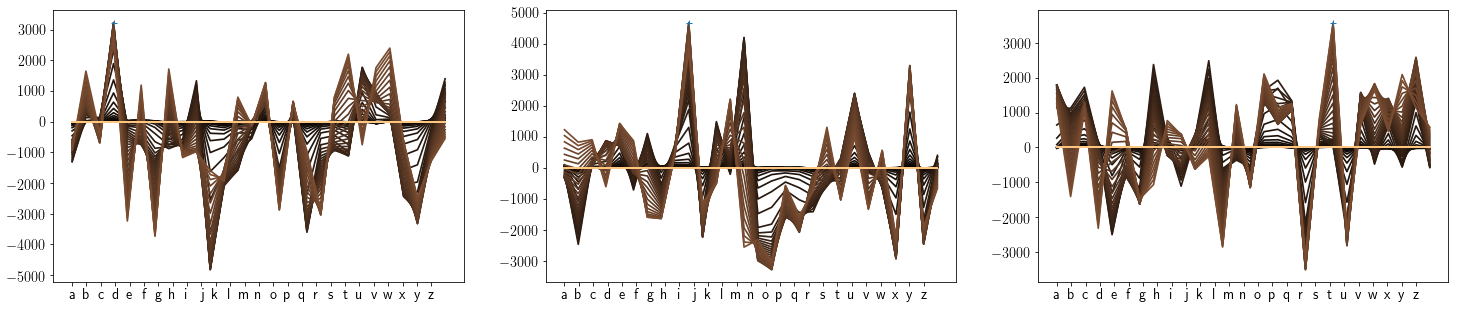

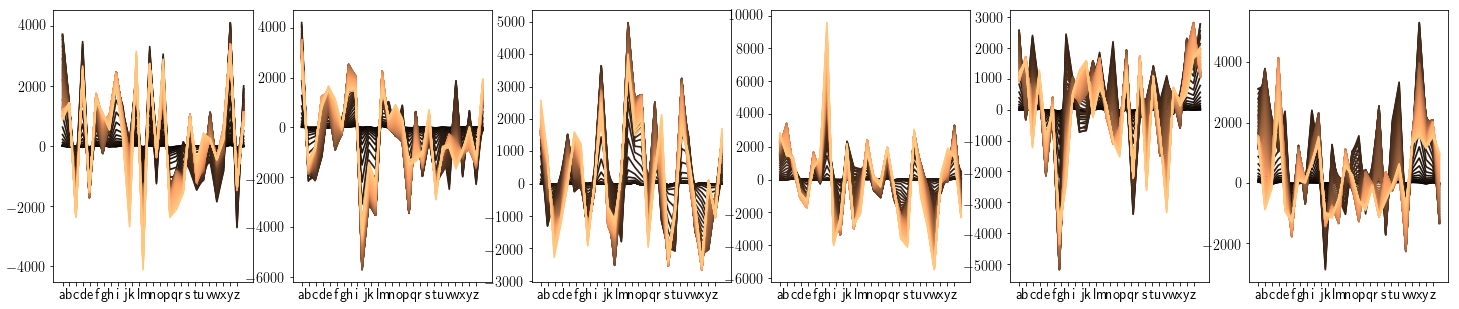

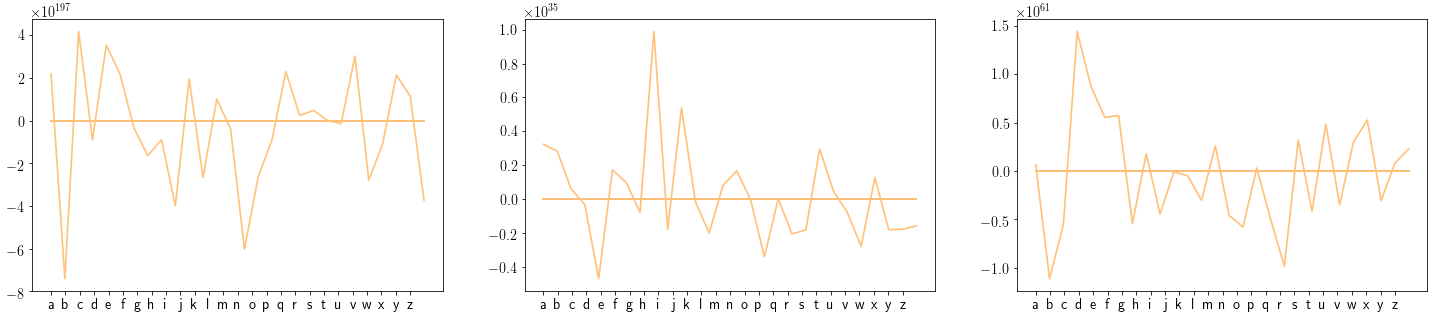

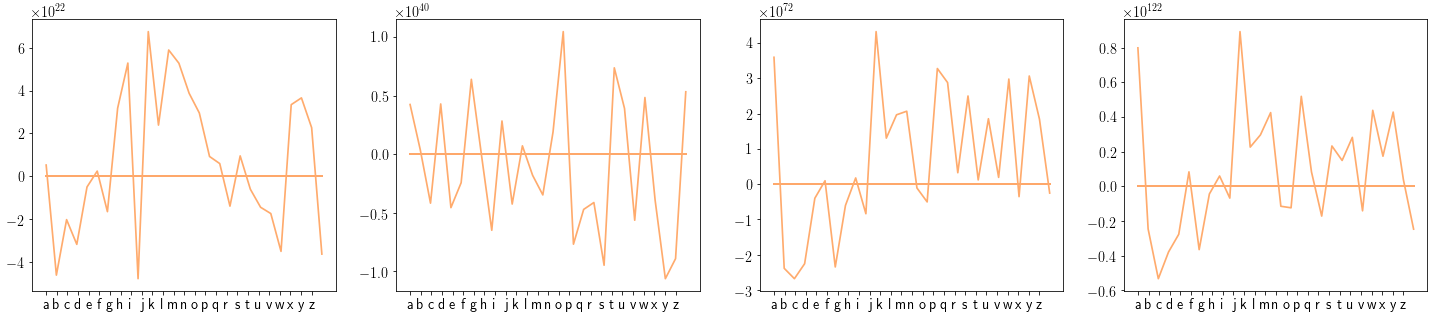

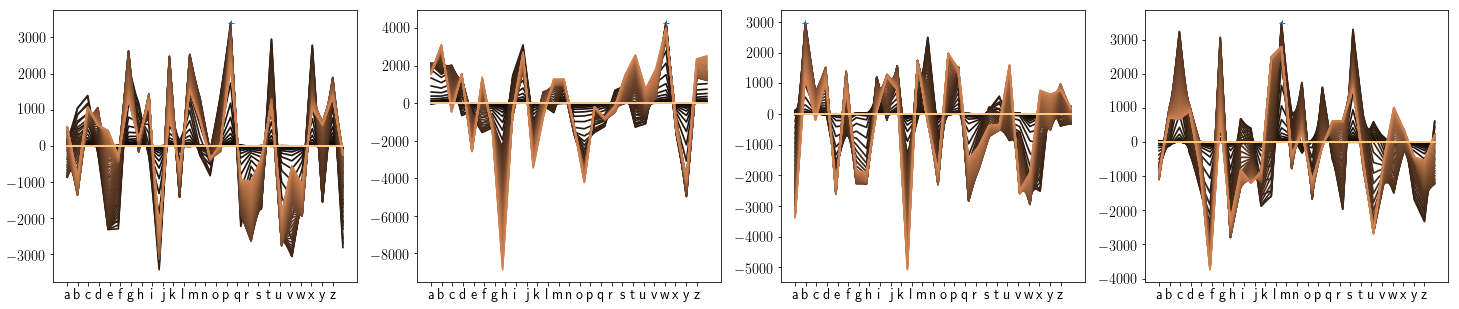

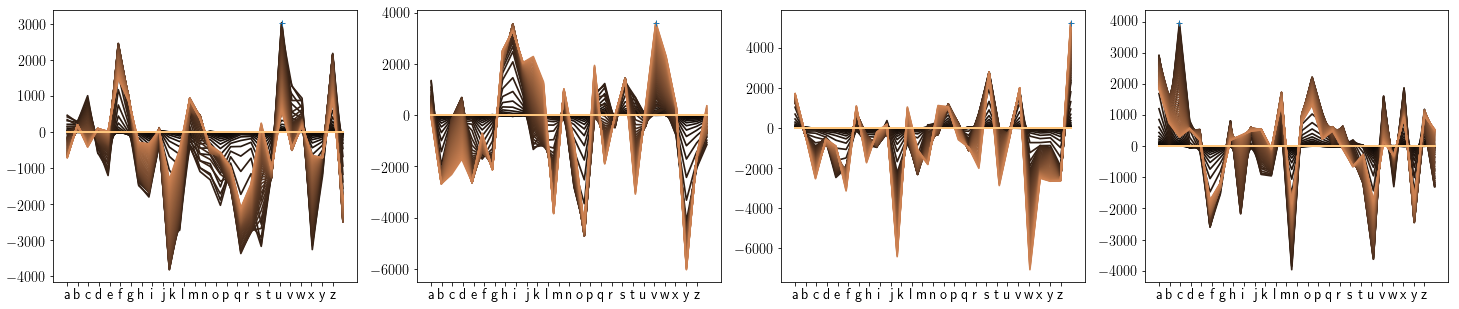

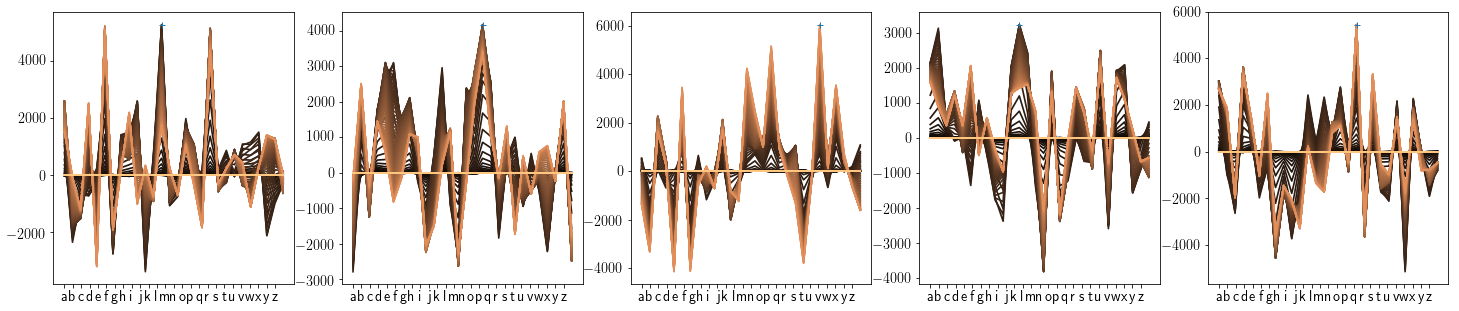

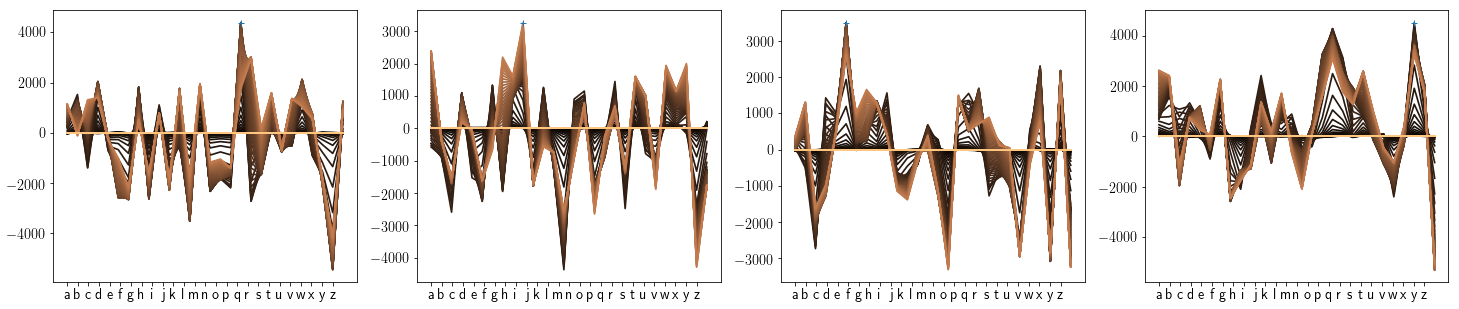

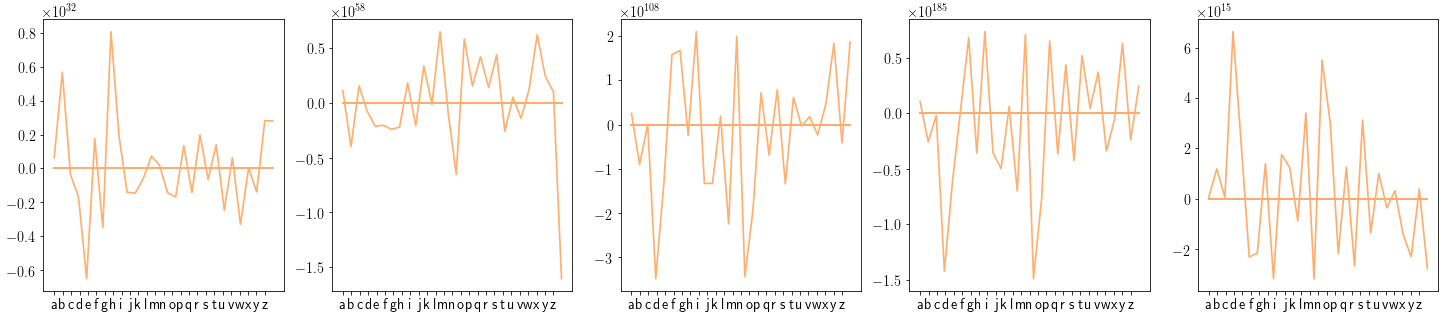

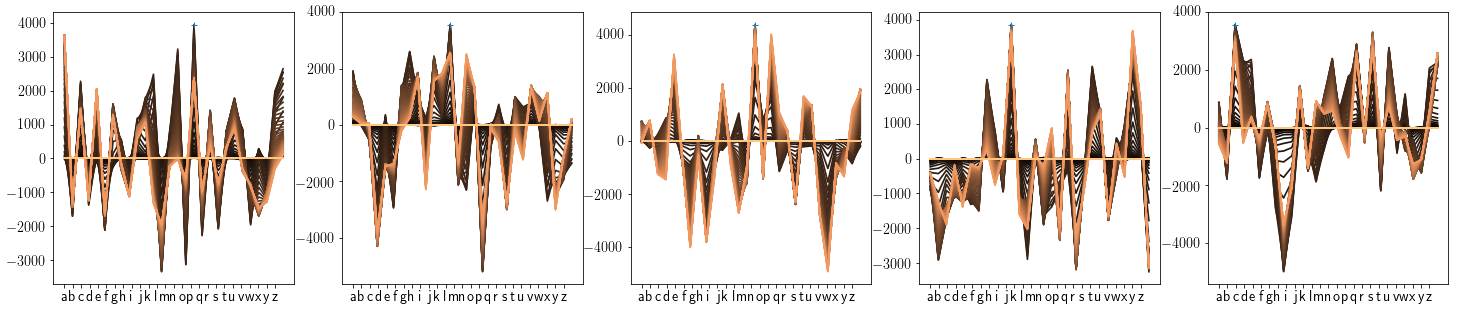

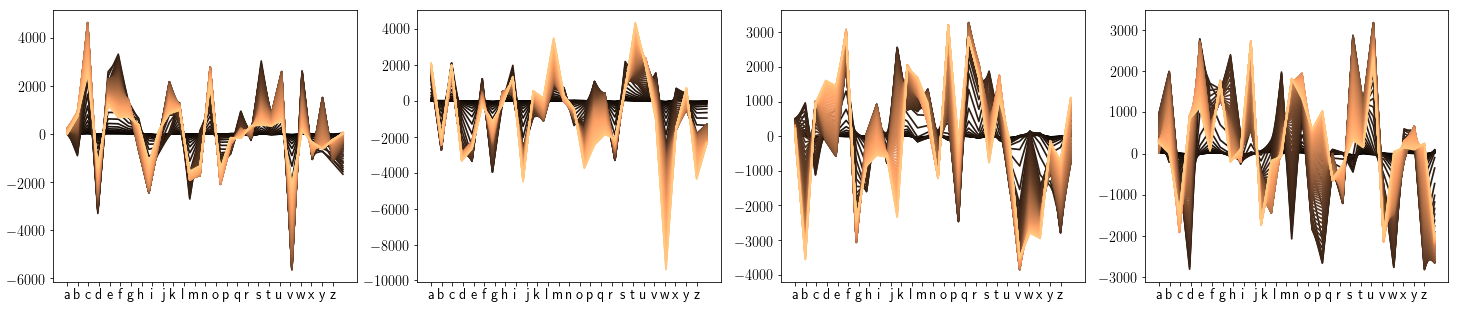

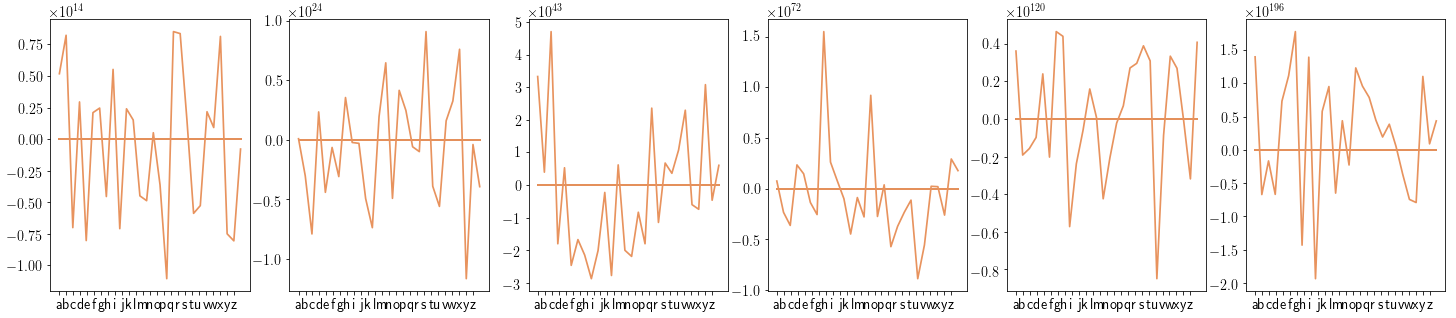

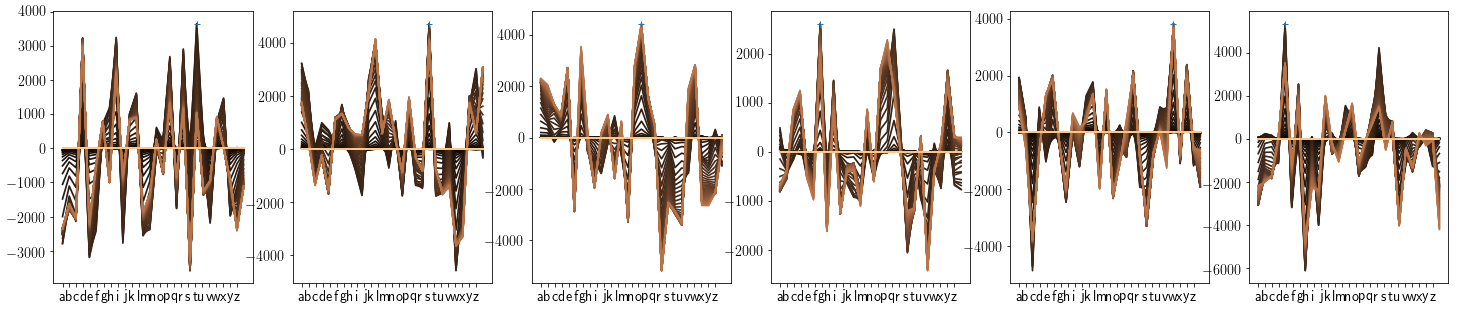

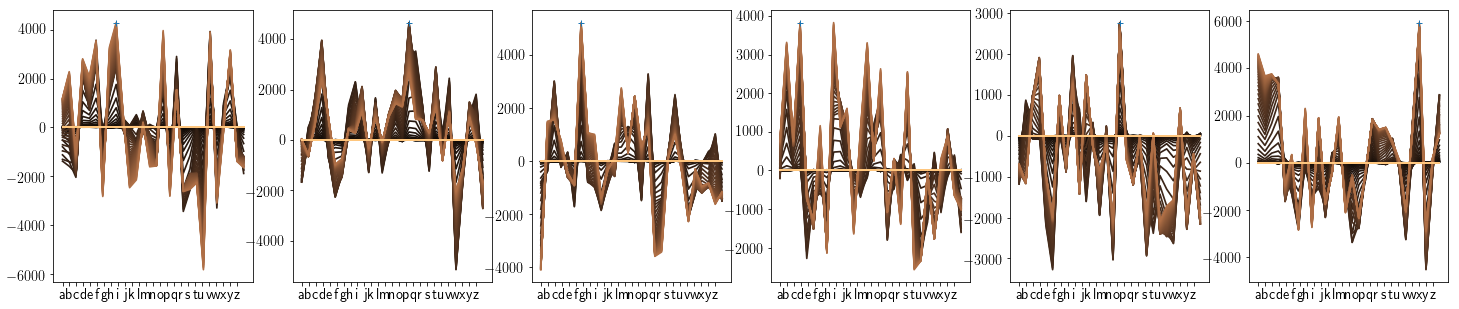

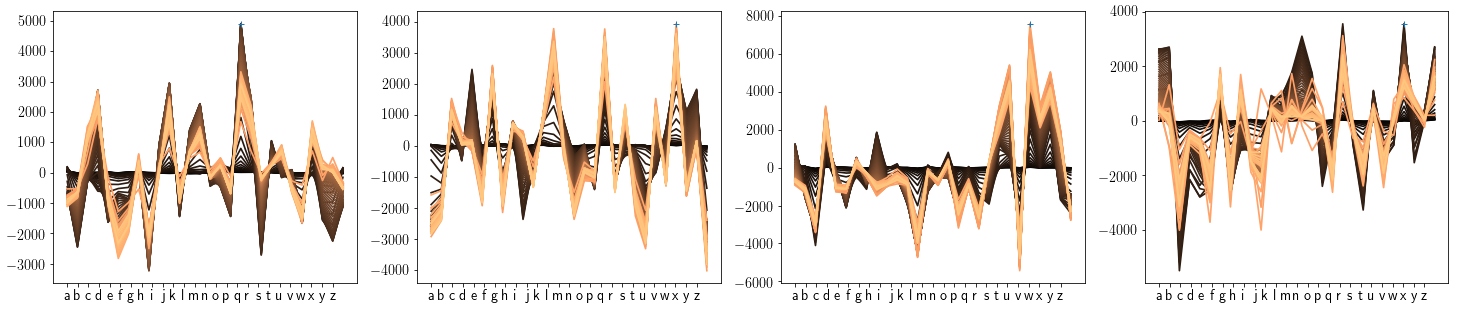

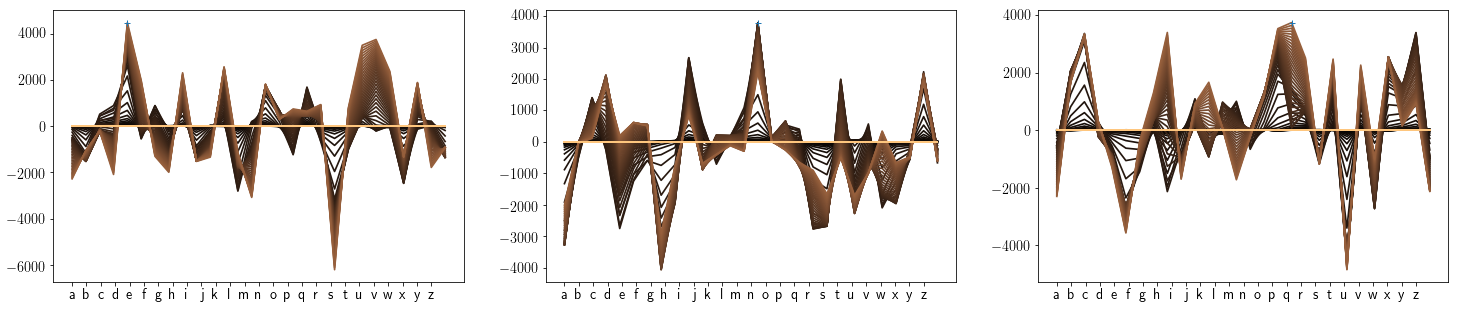

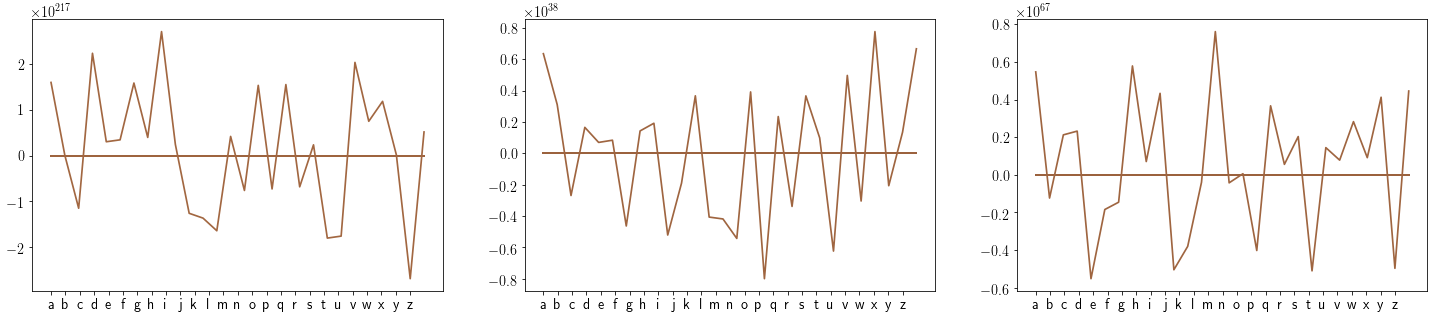

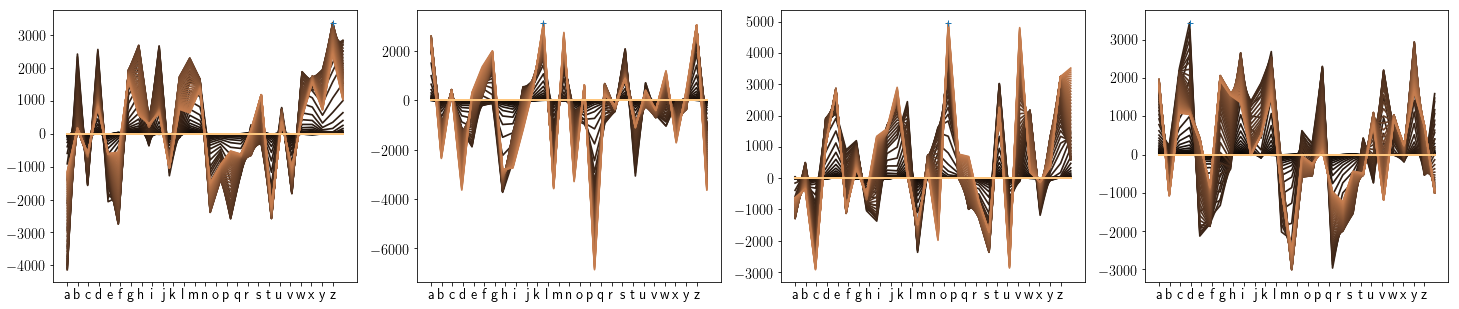

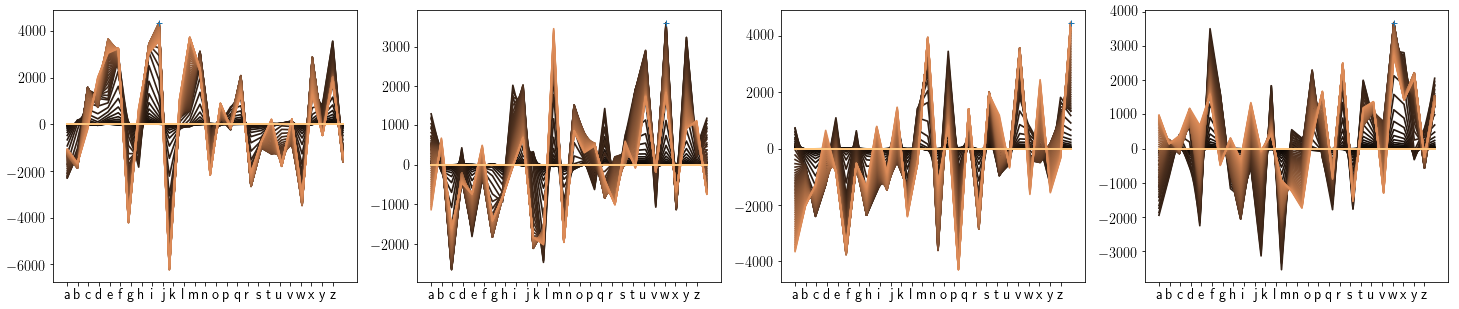

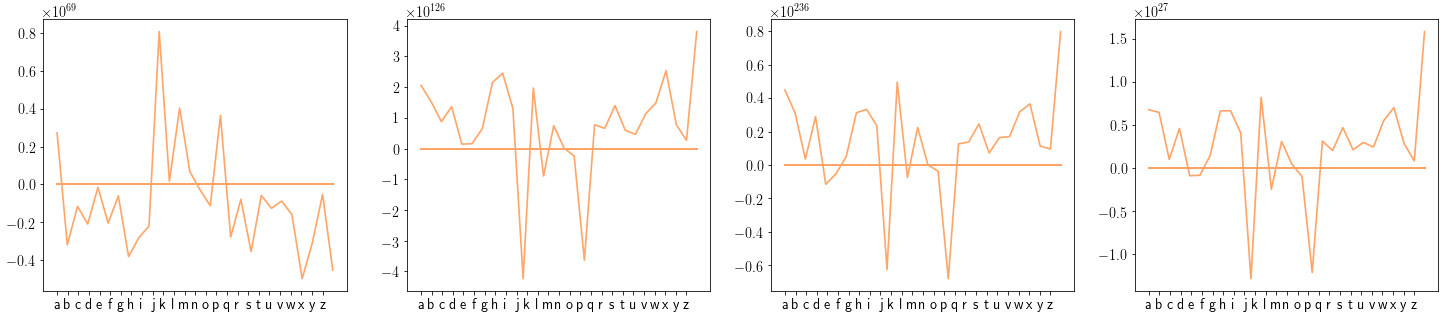

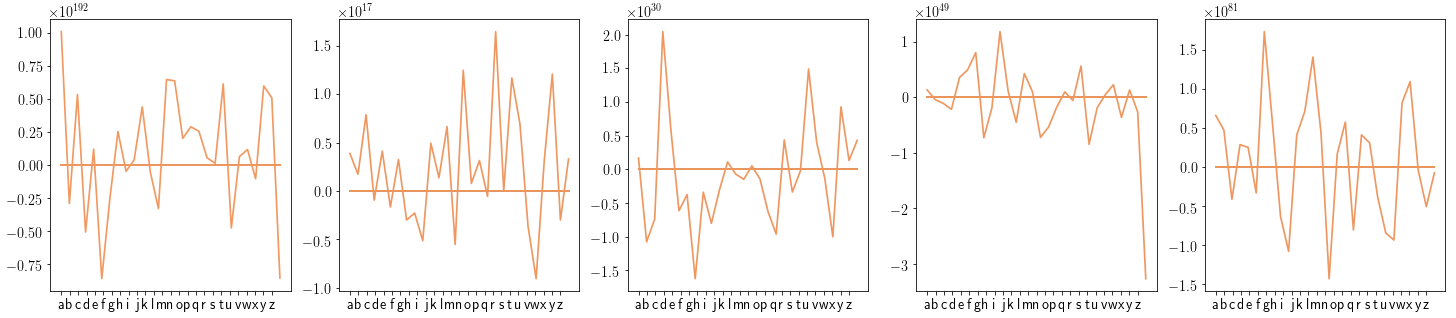

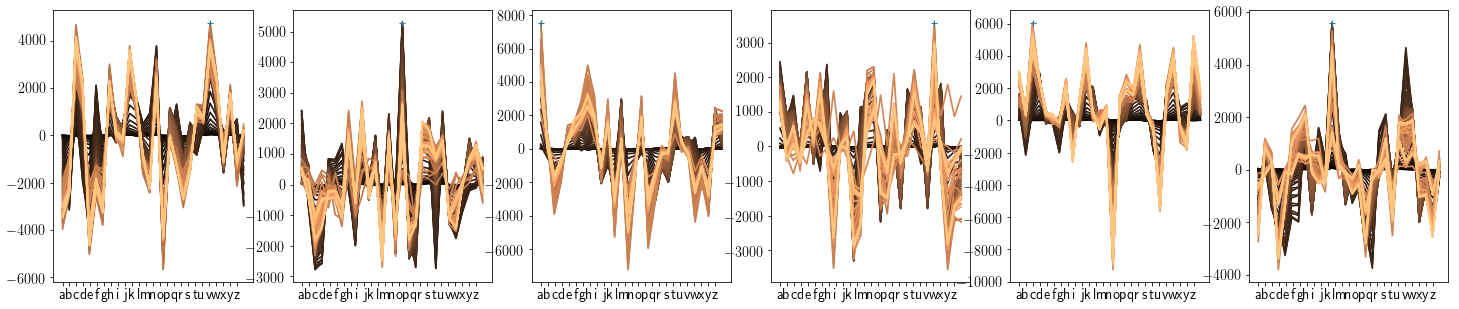

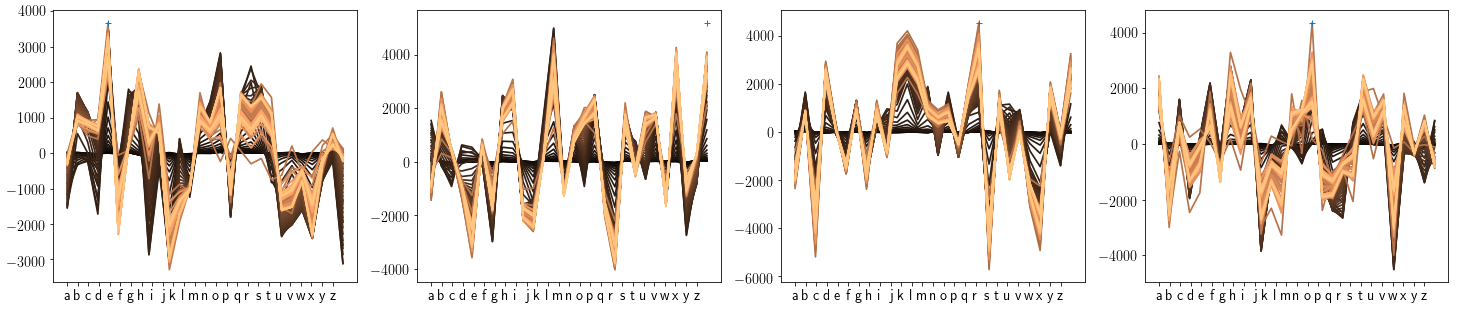

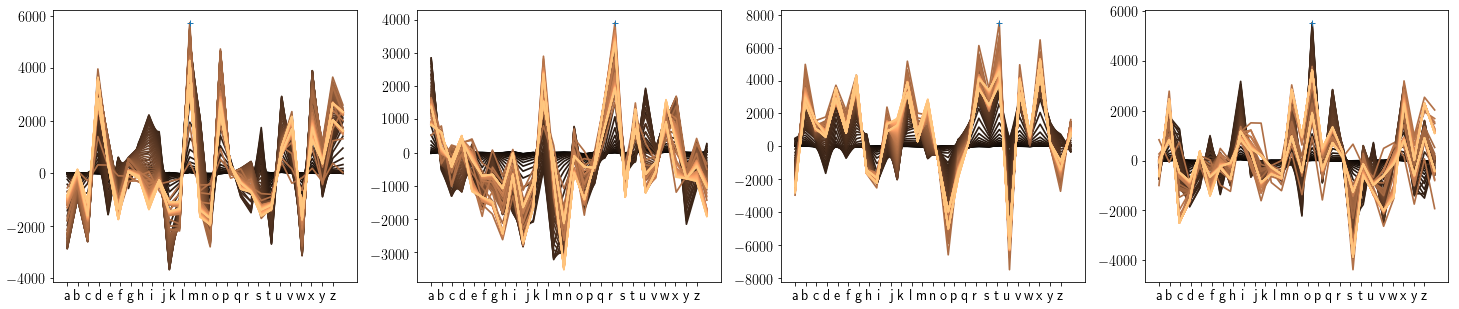

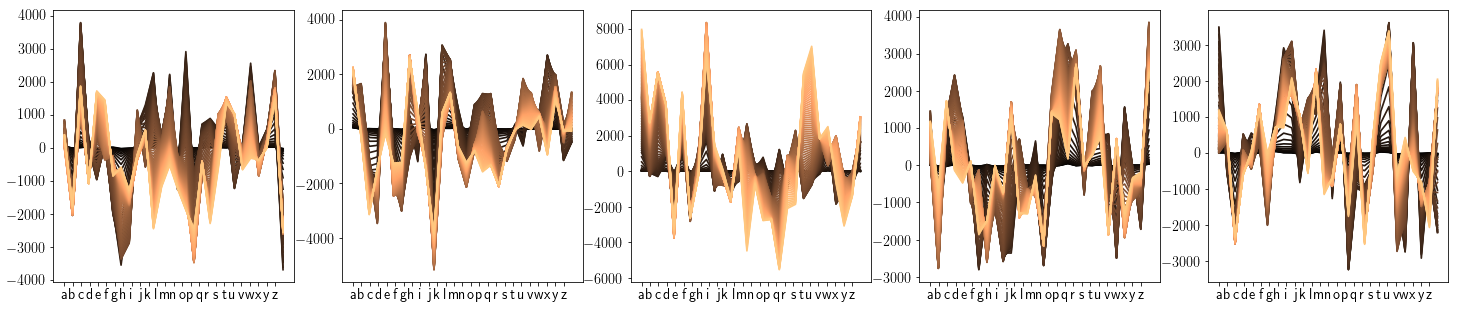

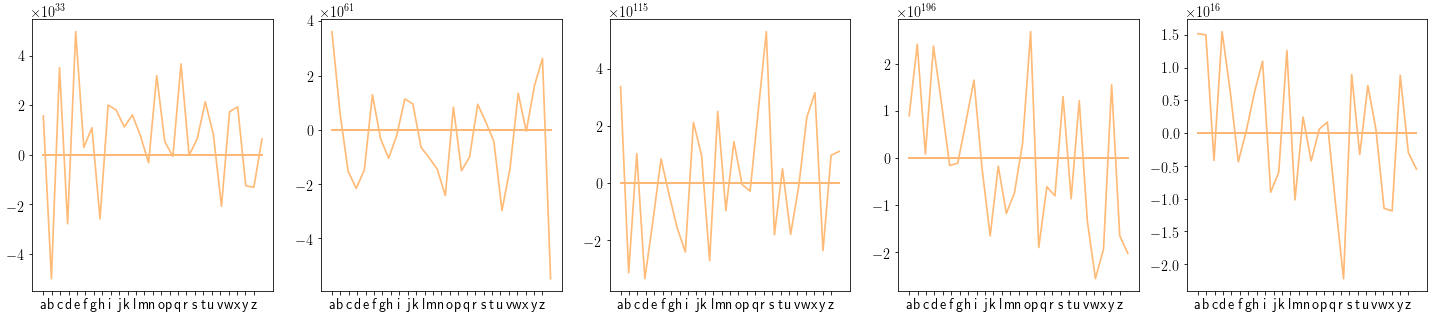

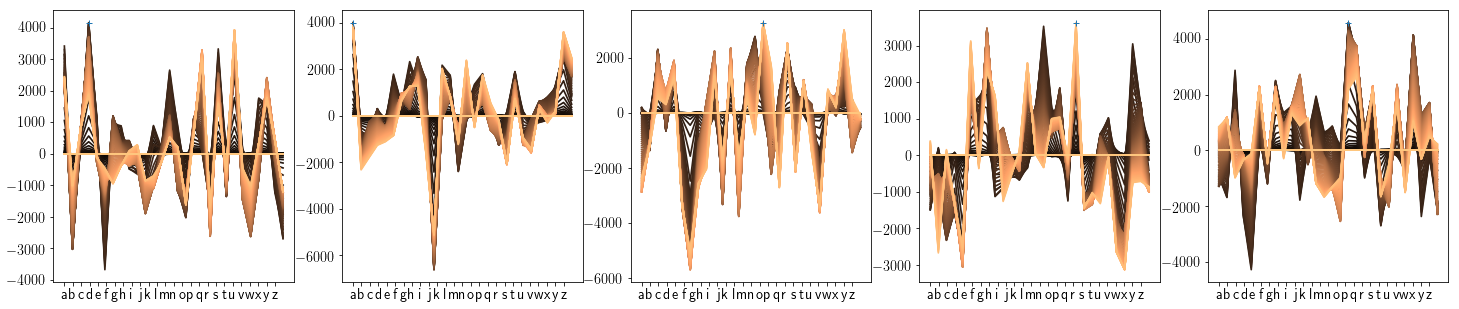

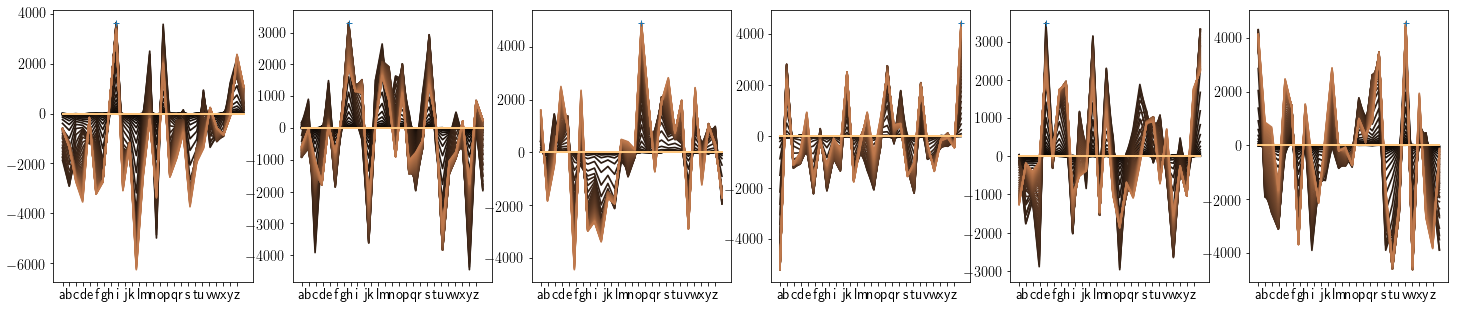

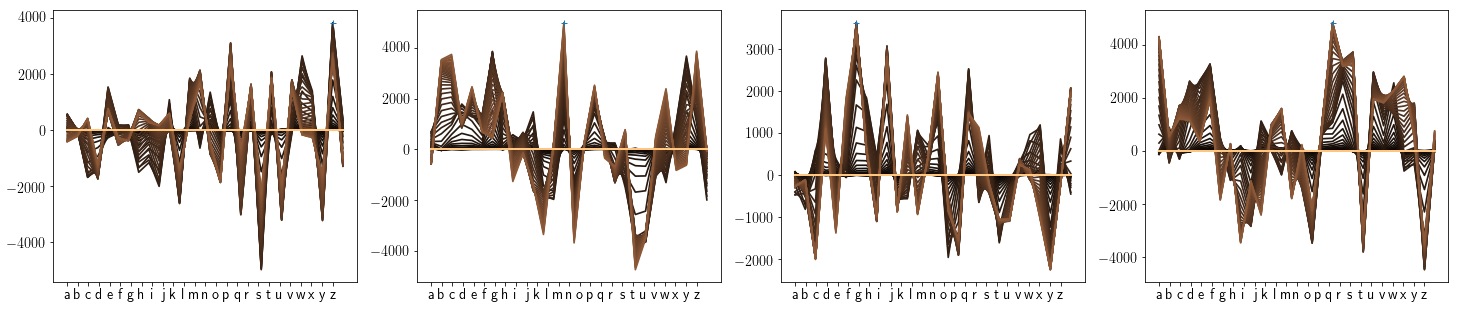

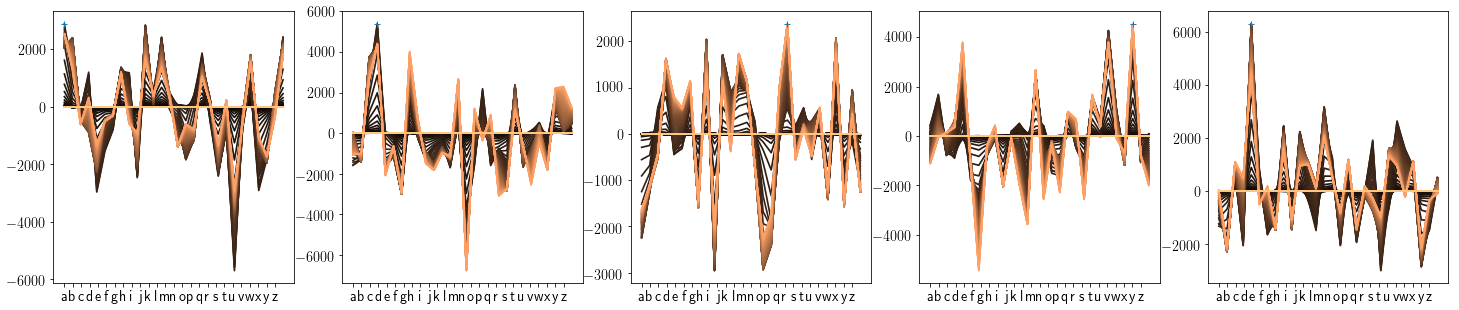

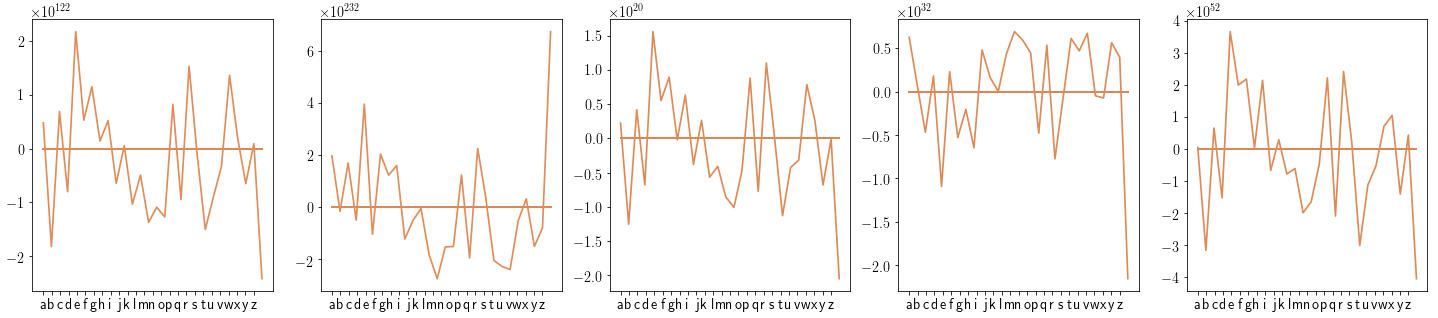

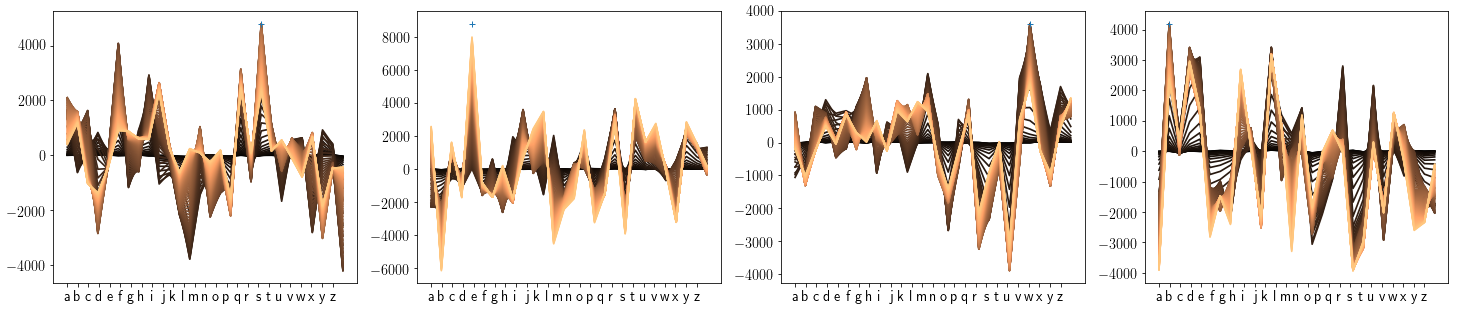

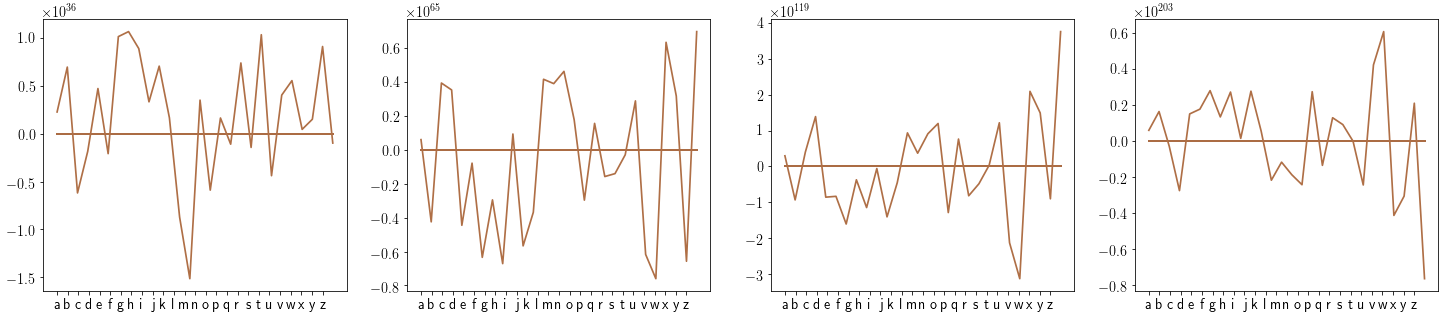

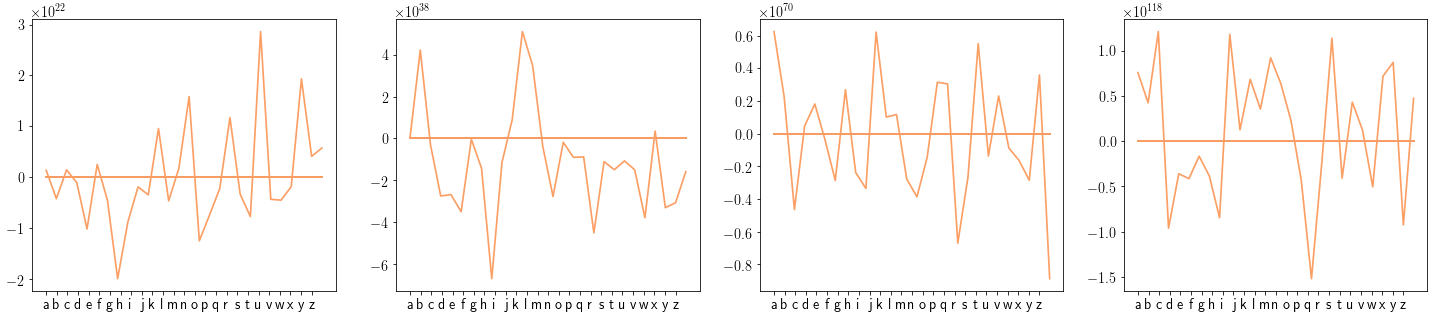

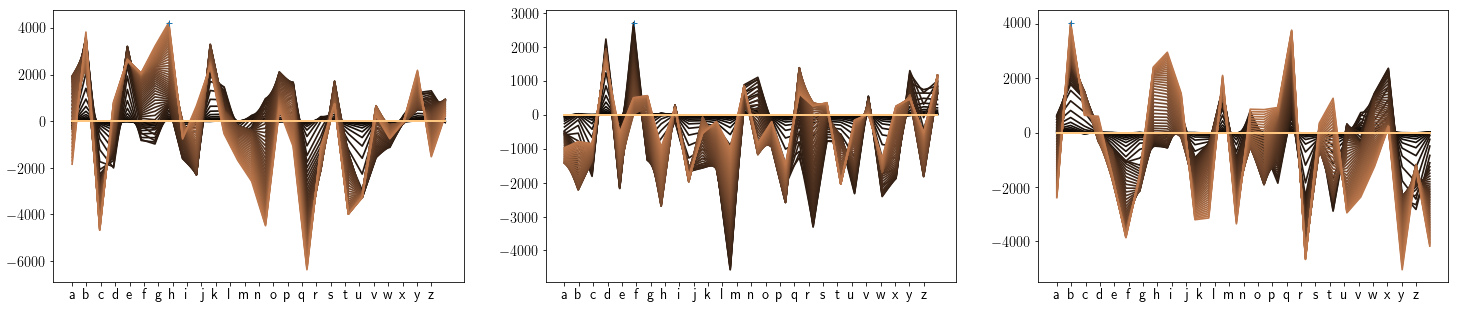

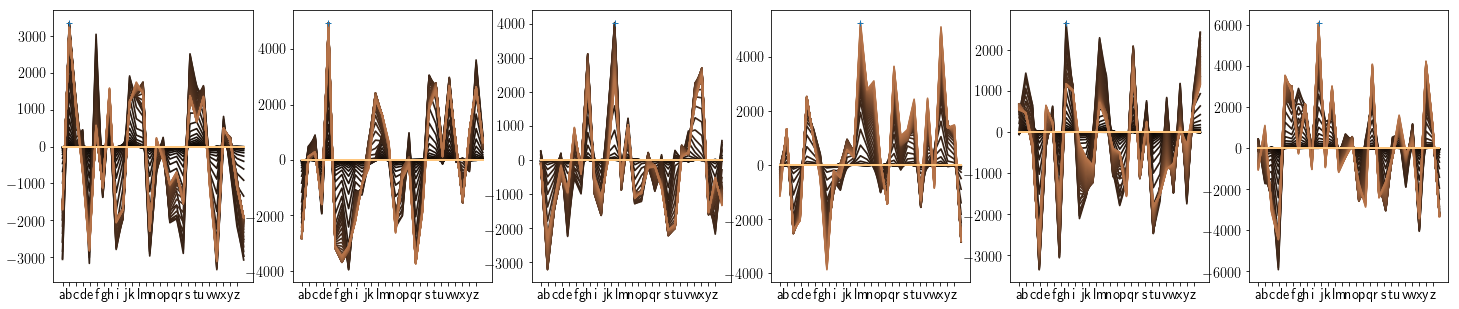

In [9]:
nsteps = 500
n_steps = 100
atol = 0.034
rtol = 0.264

# train set
for i in range(len(verbs)):
    past, pres = verbs[i][0], verbs[i][1]
    word_length = len(past)
    pred_vec = pres1[i] * bound_vec + pres2[i]
    
    states, coef_hists = state_setup(word_length+2, dic2, N, D, nsteps)
    states, coef_hists, all_converged, steps = explain_away(
        pred_vec, states, coef_hists, word_length+2, dic2, 
        N, D, atol, rtol, nsteps)

#     states, coef_hists = state_setup(word_length+2, dic2, N, D, n_steps)
#     states, coef_hists = explain_away_iterate(
#         pred_vec, states, coef_hists, word_length+2, dic2, N, D, n_steps)
    
    pred, alphis = spell(coef_hists)
    print (pred, past, alphis, steps)

#     resplot(word_length, states, coef_hists, N, nsteps, 0)
    
#     resplot(word_length, states, coef_hists, N, n_steps, 0)
print ('test set')
for i in range(len(testverbs)):
    past, pres = testverbs[i][0], testverbs[i][1]
    word_length = len(past)
    pred_vec = testpres1[i] * bound_vec + testpres2[i]
    
    states, coef_hists = state_setup(word_length+2, dic2, N, D, nsteps)
    states, coef_hists, all_converged, steps = explain_away(
        pred_vec, states, coef_hists, word_length+2, dic2, 
        N, D, atol, rtol, nsteps)

#     states, coef_hists = state_setup(word_length+2, dic2, N, D, n_steps)
#     states, coef_hists = explain_away_iterate(
#         pred_vec, states, coef_hists, word_length+2, dic2, N, D, n_steps)
    
    pred, alphis = spell(coef_hists)

    print (pred, past, alphis, steps)

    resplot(word_length, states, coef_hists, N, nsteps, 0)
    
#     resplot(word_length, states, coef_hists, N, n_steps, 0)

In [ ]:
accs = []
binaccs = []
convsteps = []

atol = 0.034
rtol = 0.264

N = 1000
n_steps = 500
# noise 
for sigma in range(5):
    accs.append([])
    binaccs.append([])
    convsteps.append([])
    print ('sigma', sigma*.01)

    # N-neurons
    for i in range(11):
        N = 1000*(2**i)
        noise = np.random.normal(0, sigma*.01, N)
        dic1 = 2 * (np.random.randn(D, N) < 0) - 1
        accs[sigma].append([])
        binaccs[sigma].append([])
        convsteps[sigma].append([])
        print ('N', N)
        
        # M-letter word
        for word_length in range(2,len(word),3):
            word_vec = ngram_encode_cl(word[:word_length], dic1, alph) + noise
            
            states, coef_hists = state_setup(word_length+2, dic1, N, D, n_steps)
            states, coef_hists, all_converged, steps = explain_away(
                word_vec, states, coef_hists, word_length+2, dic1, N, D, 
                atol, rtol, n_steps)
            pred, alphis = spell(coef_hists)
            actual = word[:word_length]
            print (pred, actual, steps)
            accs[sigma][i].append(accuracy(pred, actual))
            binaccs[sigma][i].append(1 if pred == actual else 0)
            convsteps[sigma][i].append(steps)
        
fname = ('data/res_word_trigram-03-19-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps,
         N=N, D=D, atol=atol, rtol=rtol)


('sigma', 0.0)
('N', 1000)
('s.', 'pn', 24)
('ywemh', 'pneum', 71)
('pneumono', 'pneumono', 144)
('vpezoolzklt', 'pneumonoult', 191)
('pneumocoultram', 'pneumonoultram', 216)
('vegwxndux.umolyl#', 'pneumonoultramicr', 302)
('zy#urwhehlpkxpicrosc', 'pneumonoultramicrosc', 285)
('libxhngppmvghfoapodslpi', 'pneumonoultramicroscopi', 405)
('onokjglwmsawlecdavofinmmre', 'pneumonoultramicroscopicsi', 389)
('zhijkstb#jmjuulovtdnsfph#nxpe', 'pneumonoultramicroscopicsilic', 499)
('gqyjopndqqqczdav.yrudatp.nxuttvo', 'pneumonoultramicroscopicsilicovo', 443)
('zqkcmpausifnsgbzatlisyib.gz#ybvolca', 'pneumonoultramicroscopicsilicovolca', 499)
('amhiitljqiwnwnlh#puoifnrguyshoekbtpzdo', 'pneumonoultramicroscopicsilicovolcanoc', 499)
('pw#fnbfcvdacavmjimznefzljrg#dlfmqwgcxhx..', 'pneumonoultramicroscopicsilicovolcanoconi', 446)
('scowjro#fclyskjmahdtebzuiwlyjlhnkiynsluxrmtw', 'pneumonoultramicroscopicsilicovolcanoconiosi', 392)
('N', 2000)
('pn', 'pn', 17)
('xgeum', 'pneum', 102)
('pneumohi', 'pneumono

('ymfx#ffy', 'pneumono', 2)
('lk.yiadcgaq', 'pneumonoult', 2)
('fvjjpbypjhkggx', 'pneumonoultram', 9)
('pnohtshvmfcmcrscr', 'pneumonoultramicr', 14)
('jsyoticsma#hckjpgcbr', 'pneumonoultramicrosc', 20)
('dlsklmwtmdwkdz#hfvmkswv', 'pneumonoultramicroscopi', 11)
('pdazdn.rmk#kxzuxnfsqheepvw', 'pneumonoultramicroscopicsi', 13)
('sncfookqaghihi#qhiqoymgwmthmf', 'pneumonoultramicroscopicsilic', 10)
('mojjwqgt#vfqo#kciqkjjj.xgcbb#xcx', 'pneumonoultramicroscopicsilicovo', 13)
('d#yclxslhmgnpmhjupjjcyhptkrtryiryxr', 'pneumonoultramicroscopicsilicovolca', 11)
('uohmfmuo#uorjtqamv..htuaweptrpga.fmirp', 'pneumonoultramicroscopicsilicovolcanoc', 2)
('dy##x.mkp.wmpdtpawhusmpclrbzgqnvlgslnwyum', 'pneumonoultramicroscopicsilicovolcanoconi', 2)
('ndmvir.sngyrzcvxchbg#ojxsebgoq.sxjquptnyovtq', 'pneumonoultramicroscopicsilicovolcanoconiosi', 19)
('N', 1024000)
('vs', 'pn', 28)
('vseum', 'pneum', 86)
('zc#fkdwa', 'pneumono', 10)
('xauxjokdcbn', 'pneumonoult', 2)
('#ftwaqenqyocd.', 'pneumonoultram', 5)
('

('pneumonoumorkx', 'pneumonoultram', 310)
('pneumonoultramicr', 'pneumonoultramicr', 257)
('myew#oueultramicrosc', 'pneumonoultramicrosc', 358)
('zlxgihnrqpzhsu.#qz#.bqq', 'pneumonoultramicroscopi', 17)
('i.zyo#sk#fqnykhhsccw.dkqii', 'pneumonoultramicroscopicsi', 26)
('ysheoszlmc.dh#w.fmtmuhbjc#gnf', 'pneumonoultramicroscopicsilic', 9)
('qrcrhsqamfjtchdqgcqixz.lr#uowg.m', 'pneumonoultramicroscopicsilicovo', 6)
('xibdallknhowwie#.lmtec#wvemqmqwh#kv', 'pneumonoultramicroscopicsilicovolca', 14)
('xpbnvcxtmaf#nxvlhmsywzvqbzy.d.exj#syro', 'pneumonoultramicroscopicsilicovolcanoc', 2)
('oajzoskpvotdm#lvppovjidbengonmljlyzbrytzl', 'pneumonoultramicroscopicsilicovolcanoconi', 3)
('mc#nywbth#ggupvklkxviwvr#unbe#raeotablxbmysi', 'pneumonoultramicroscopicsilicovolcanoconiosi', 7)
('N', 256000)
('pn', 'pn', 30)
('pulym', 'pneum', 11)
('yciaf.bx', 'pneumono', 16)
('fjy#bseaclt', 'pneumonoult', 23)
('pxnnyqsavyvmhj', 'pneumonoultram', 17)
('#.thilidiujj#tjkk', 'pneumonoultramicr', 9)
('u.wlxwuub#n.sm

('pncfthlsk#wrlbomoupx', 'pneumonoultramicrosc', 11)
('iqep#oceumoramicroscopi', 'pneumonoultramicroscopi', 410)
('pneumonoultramcoultramicsi', 'pneumonoultramicroscopicsi', 499)
('pneumonoultramincoscopicramic', 'pneumonoultramicroscopicsilic', 499)
('i.e.copeumcrosiledsorpicrimicovo', 'pneumonoultramicroscopicsilicovo', 499)
('pneumonoultramiedzxduoscovllfo.plin', 'pneumonoultramicroscopicsilicovolca', 499)
('uopivlludgxzua.#pgxyslhxfqudsnhpzlvpoc', 'pneumonoultramicroscopicsilicovolcanoc', 72)
('th.fqny#xgykyoereuauxaw.vlcgyialccypfelon', 'pneumonoultramicroscopicsilicovolcanoconi', 5)
('i#eonocccrorujwexhu#jlhbiljtjoullramiconicsi', 'pneumonoultramicroscopicsilicovolcanoconiosi', 499)
('N', 64000)
('pn', 'pn', 27)
('rntyo', 'pneum', 7)
('dufbdca.', 'pneumono', 2)
('oteplo#nuib', 'pneumonoult', 162)
('nxehionoultram', 'pneumonoultram', 258)
('pneumonouqorbiieh', 'pneumonoultramicr', 255)
('h.em#oueultramicrosc', 'pneumonoultramicrosc', 336)
('pneumonoultrhlitzoemoco', 'pneumonoultra

('g.ecworeucjtcsridlinalwclv', 'pneumonoultramicroscopicsi', 499)
('pneumonoultramiosossilicromic', 'pneumonoultramicroscopicsilic', 499)
('pneumonoultramilpbscroscovmwvoqw', 'pneumonoultramicroscopicsilicovo', 499)
('gaelcopeucvrswillixganscovlwkoqnlic', 'pneumonoultramicroscopicsilicovolca', 499)
('mteicopioolmpcmd#sojlrzmjopicsiliconoc', 'pneumonoultramicroscopicsilicovolcanoc', 499)
('q.elloescojjtpjayzucmgvo.jzuxamicvoliconi', 'pneumonoultramicroscopicsilicovolcanoconi', 499)
('pneumonoccanbjagzwojowzbv.fbmmtllramoconiosi', 'pneumonoultramicroscopicsilicovolcanoconiosi', 499)
('N', 16000)
('pn', 'pn', 19)
('vieqw', 'pneum', 73)
('epeqooiu', 'pneumono', 108)
('xgacylqsoil', 'pneumonoult', 2)
('vcev#oulultram', 'pneumonoultram', 225)
('vieh#oulultramicr', 'pneumonoultramicr', 243)
('pneumonoultramicrosc', 'pneumonoultramicrosc', 300)
('dijdgzxnorkmy#.dlnawztg', 'pneumonoultramicroscopi', 27)
('ckezuoweumwroyicroscopicsi', 'pneumonoultramicroscopicsi', 499)
('pneumonoultramiinoccopic

('fyoj.olhhofavgyewp#boudsznsisrle', 'pneumonoultramicroscopicsilicovo', 499)
('#gejvotkoocfwzjsndghhluwr.jhtbjmdyw', 'pneumonoultramicroscopicsilicovolca', 499)
('epop#izpecwbxsapprcrhdzvvzql.sgcvqtgg#', 'pneumonoultramicroscopicsilicovolcanoc', 499)
('maeooincrormg.ex#kkafrmtbqplqqhenthmoconi', 'pneumonoultramicroscopicsilicovolcanoconi', 499)
('ptniosiovcvwrzhhgmhvi#udqiuxzeftpc#vyjig#oga', 'pneumonoultramicroscopicsilicovolcanoconiosi', 499)
('N', 4000)
('gf', 'pn', 21)
('xbeum', 'pneum', 89)
('pneumoeu', 'pneumono', 122)
('pneumonoult', 'pneumonoult', 149)
('zbeedobeumwrh#', 'pneumonoultram', 230)
('pneumonoultramicr', 'pneumonoultramicr', 260)
('pneumonoultramicrosc', 'pneumonoultramicrosc', 340)
('smed#obeumoramicroscopi', 'pneumonoultramicroscopi', 387)
('pneumonoultr.wcptlpwaofcdr', 'pneumonoultramicroscopicsi', 499)
('pneumonicopiaeboarmuirwoiuoic', 'pneumonoultramicroscopicsilic', 499)
('fhewhtiomd.yz#r#ll.miuitramicovo', 'pneumonoultramicroscopicsilicovo', 499)
('lcvkxevysq

In [54]:
fname = ('data/res_word_trigram-03-19-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps,
         N=N, D=D, atol=atol, rtol=rtol)

In [56]:
f = np.load('data/res_word_trigram-03-19-2018-N=1024000-D=28-n180323.npz')


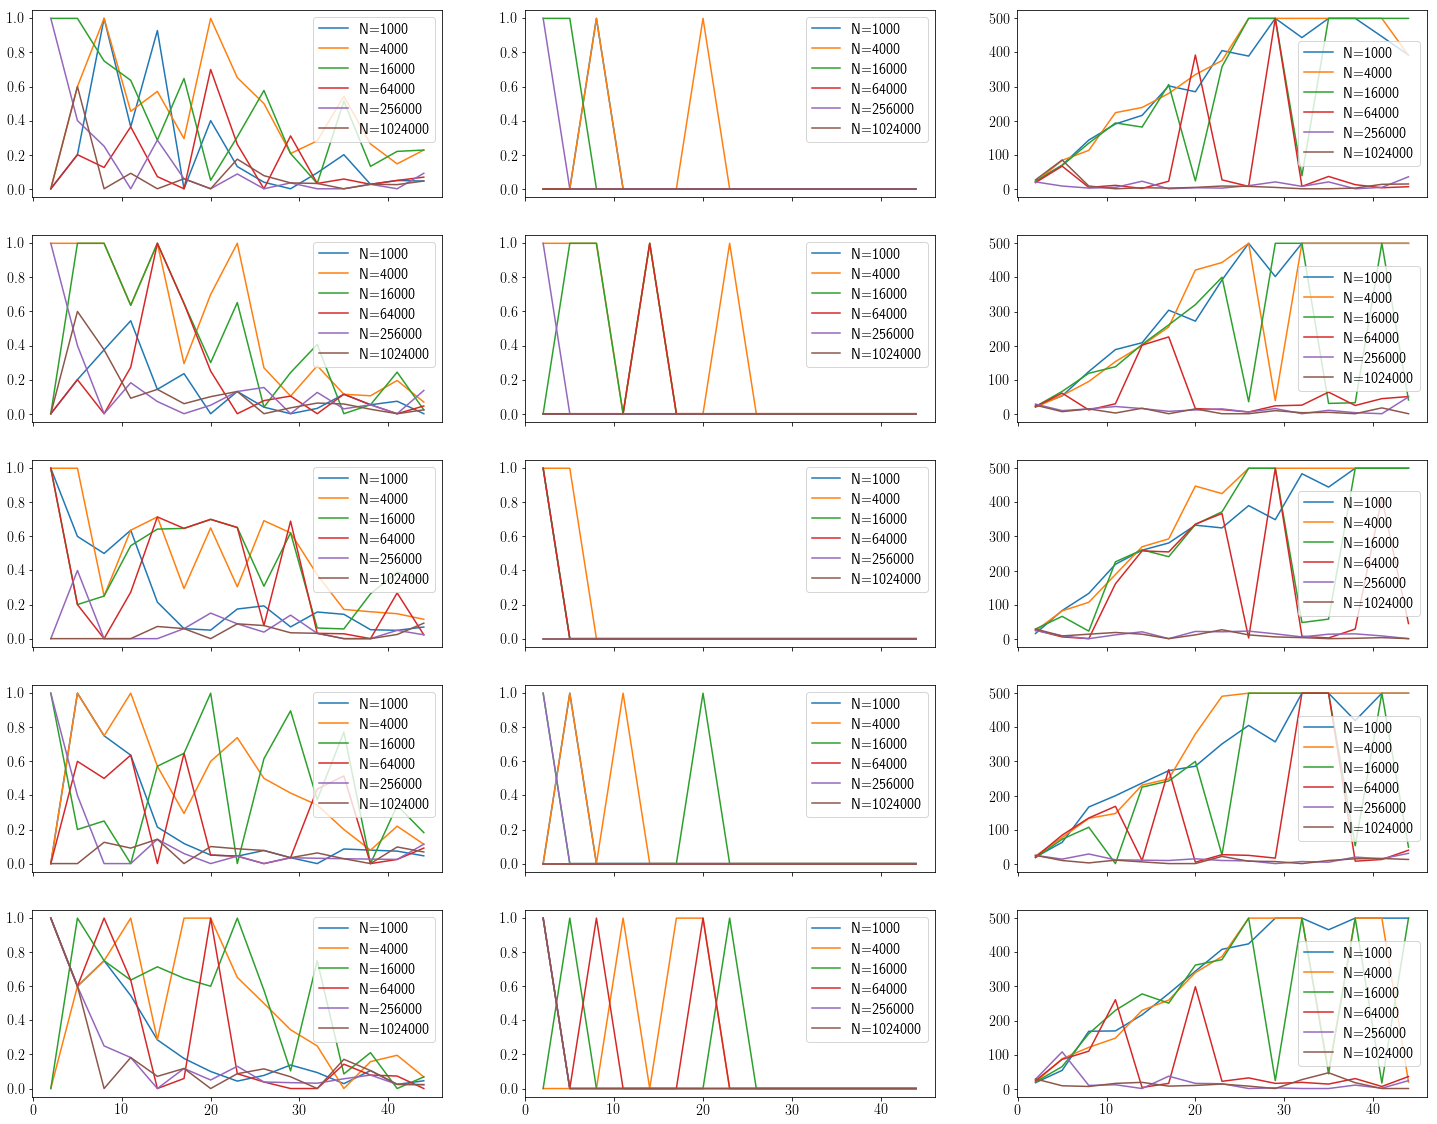

In [76]:
rows = len(f['accs'])
columns = 3

fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,20))
x = [i for i in range(2,len(word),3)]

for j in range(rows):
    for k in range(0, len(f['accs'][j]), 2):
        axes[j][0].plot(x, f['accs'][j][k], label='N='+str(1000*(2**k)))
        axes[j][1].plot(x, f['binaccs'][j][k], label='N='+str(1000*(2**k)))
        axes[j][2].plot(x, f['convsteps'][j][k], label='N='+str(1000*(2**k)))
    axes[j][0].legend()
    axes[j][1].legend()
    axes[j][2].legend()


In [ ]:
atols = []
rtols = []

N = 5000
word_length = 5
nsteps = 100

for i in range(8,100):
    for j in range(1,100):
#         print ('i,j', i, j)
        atol = i*.0005
        rtol = j*.0005
        
        dic1 = 2 * (np.random.randn(D, N) < 0) - 1
        
        word_vec = ngram_encode_cl(word[:word_length], dic1, alph)
        states, coef_hists = state_setup(word_length+2, dic1, N, D, nsteps)

        states, coef_hists, all_converged, steps = explain_away(word_vec, states, coef_hists, word_length+2, dic1, N, D, atol, rtol, nsteps)
        pred, alphis = spell(coef_hists)
        actual = word[:word_length]
        if pred == actual and np.all(all_converged) and steps < nsteps-1:
            print ('atol', atol)
            print ('rtol', rtol)
            print (pred, actual, all_converged, steps)
            atols.append(atol)
            rtols.append(rtol)